## Getting the GSS Data

Since the data files are about 40GB zipped, we can't store a compressed or uncompressed version on GitHub, and the entire dataset can't really be loaded into memory with Colab.

One option is to use Rivana: Download the data, unzip it, and work on it in a persistent environment.

The other option is to avoid opening the entire file at once, and instead work with chunks of the data. That's what this code does for you.

On GitHub, the data are broken into three smaller files, saved in .parquet format. The code below will load these chunks into memory, one at a time, you can specify the variables you want in `var_list`, and the results will be saved in `selected_gss_data.csv`.

You can add more cleaning instructions in between the lines where the data are loaded ( `df = pd.read_parquet(url)`) and the data are saved (`df.loc...`). It's probably easiest to use this code to get only the variables you want, and then clean that subset of the data.

In [4]:
import pandas as pd
#
var_list = ['year','suicide1', 'suicide2','suicide3','suicide4'] # List of variables you want to save
output_filename = 'gss_suicide_data.csv' # Name of the file you want to save the data to
#
modes = ['w','a'] # Has write mode and append mode
phase = 0 # Starts in write mode; after one iteration of loop, switches to append mode
#
for k in range(3): # for each chunk of the data
    url = 'https://github.com/DS3001/project_gss/raw/main/gss_chunk_' + str(1+k) + '.parquet' # Create url to the chunk to be processed
    print(url) # Check the url is correct
    df = pd.read_parquet(url) # Download this chunk of data
    print(df.head()) # Visually inspect the first few rows
    df.loc[:,var_list].to_csv(output_filename, # specifies target file to save the chunk to
                              mode=modes[phase], # control write versus append
                              header=var_list, # variable names
                              index=False) # no row index saved
    phase = 1 # Switch from write mode to append mode

https://github.com/DS3001/project_gss/raw/main/gss_chunk_1.parquet
   year  id            wrkstat  hrs1  hrs2 evwork    occ  prestige  \
0  1972   1  working full time   NaN   NaN    NaN  205.0      50.0   
1  1972   2            retired   NaN   NaN    yes  441.0      45.0   
2  1972   3  working part time   NaN   NaN    NaN  270.0      44.0   
3  1972   4  working full time   NaN   NaN    NaN    1.0      57.0   
4  1972   5      keeping house   NaN   NaN    yes  385.0      40.0   

         wrkslf wrkgovt  ...  agehef12 agehef13 agehef14  hompoph wtssps_nea  \
0  someone else     NaN  ...       NaN      NaN      NaN      NaN        NaN   
1  someone else     NaN  ...       NaN      NaN      NaN      NaN        NaN   
2  someone else     NaN  ...       NaN      NaN      NaN      NaN        NaN   
3  someone else     NaN  ...       NaN      NaN      NaN      NaN        NaN   
4  someone else     NaN  ...       NaN      NaN      NaN      NaN        NaN   

   wtssnrps_nea  wtssps_next wt

In [5]:
df = pd.read_csv('/content/gss_suicide_data.csv')
print(df.head())

   year suicide1 suicide2 suicide3 suicide4
0  1972      NaN      NaN      NaN      NaN
1  1972      NaN      NaN      NaN      NaN
2  1972      NaN      NaN      NaN      NaN
3  1972      NaN      NaN      NaN      NaN
4  1972      NaN      NaN      NaN      NaN


In [6]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in {column}:\n{unique_values}\n")

Unique values in year:
['1972' '1973' '1974' '1975' '1976' '1977' '1978' '1980' '1982' '1983'
 '1984' '1985' '1986' '1987' '1988' '1989' 'year' '1990' '1991' '1993'
 '1994' '1996' '1998' '2000' '2002' '2004' '2006' '2008' '2010' '2012'
 '2014' '2016' '2018' '2021' '2022']

Unique values in suicide1:
[nan 'no' 'yes' 'suicide1']

Unique values in suicide2:
[nan 'no' 'yes' 'suicide2']

Unique values in suicide3:
[nan 'no' 'yes' 'suicide3']

Unique values in suicide4:
[nan 'no' 'yes' 'suicide4']



> In the codebook, there are labels for all four suicide variables: YES (yes), NO (no), DONT'T KNOW(D), NO ANSWER(N), NOT APPLICABLE (I), SKIPPED ON WEB(S) – a total of 6 labels. Besides 'yes' or 'no', others appear as reserved codes.

> As shown in the summary above, all four suicide variables only have 3 unique values: 'yes', 'no', or 'nan'. So, before the dataset is output, it seems like the unuseful and uninformative values have already been cleaned into 'NaN'.

In [7]:
summary = pd.DataFrame({
    'Variable': ['suicide1', 'suicide2', 'suicide3', 'suicide4'],
    'NaN Count': [df['suicide1'].isna().sum(), df['suicide2'].isna().sum(), df['suicide3'].isna().sum(), df['suicide4'].isna().sum()],
    'Yes Count': [df['suicide1'].eq('yes').sum(), df['suicide2'].eq('yes').sum(), df['suicide3'].eq('yes').sum(), df['suicide4'].eq('yes').sum()],
    'No Count': [df['suicide1'].eq('no').sum(), df['suicide2'].eq('no').sum(), df['suicide3'].eq('no').sum(), df['suicide4'].eq('no').sum()],
})

print(summary)

   Variable  NaN Count  Yes Count  No Count
0  suicide1      36268      20771     15351
1  suicide2      35322       3437     33631
2  suicide3      35385       3411     33594
3  suicide4      35809       6160     30421


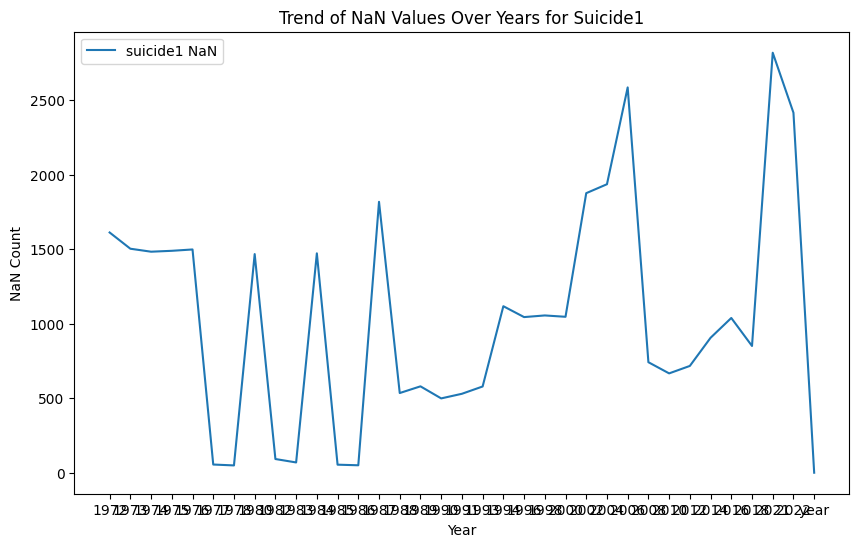

In [8]:
import matplotlib.pyplot as plt

nan_counts = df.groupby('year')['suicide1'].apply(lambda x: x.isna().sum())

# Plot the trend over years
plt.figure(figsize=(10, 6))
plt.plot(nan_counts.index, nan_counts.values, label='suicide1 NaN')

plt.xlabel('Year')
plt.ylabel('NaN Count')
plt.title('Trend of NaN Values Over Years for Suicide1')
plt.legend()
plt.show()

In [9]:
# Check Vars type
print(df.dtypes)

year        object
suicide1    object
suicide2    object
suicide3    object
suicide4    object
dtype: object


In [10]:
# Convert categorical to numerical
df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

yes_no_mapping = {'yes': 1, 'no': 0}
# Apply the mapping using a for loop
for col in ['suicide1', 'suicide2', 'suicide3', 'suicide4']:
    df[col] = df[col].map(yes_no_mapping)

In [11]:
print(df.dtypes)
# convert done

year          Int64
suicide1    float64
suicide2    float64
suicide3    float64
suicide4    float64
dtype: object


In [12]:
# Clean NaN
df = df.dropna(subset=['year','suicide1', 'suicide2', 'suicide3', 'suicide4'])
print(df.head())

      year  suicide1  suicide2  suicide3  suicide4
7590  1977       0.0       0.0       0.0       0.0
7591  1977       1.0       1.0       1.0       1.0
7592  1977       0.0       0.0       0.0       0.0
7593  1977       1.0       0.0       0.0       0.0
7594  1977       1.0       0.0       0.0       0.0


In [13]:
df.isna().sum()
# cleaned

year        0
suicide1    0
suicide2    0
suicide3    0
suicide4    0
dtype: int64

In [14]:
df.sort_values('year')
# make sure the dataset is sorted along years

,year,suicide1,suicide2,suicide3,suicide4
7590,1977,0.0,0.0,0.0,0.0
8616,1977,0.0,0.0,0.0,0.0
8615,1977,1.0,0.0,0.0,0.0
8614,1977,1.0,0.0,0.0,0.0
8613,1977,0.0,0.0,0.0,0.0
...,...,...,...,...,...
70036,2022,0.0,0.0,0.0,0.0
70035,2022,0.0,0.0,0.0,0.0
70033,2022,1.0,0.0,0.0,0.0
70054,2022,1.0,0.0,0.0,0.0


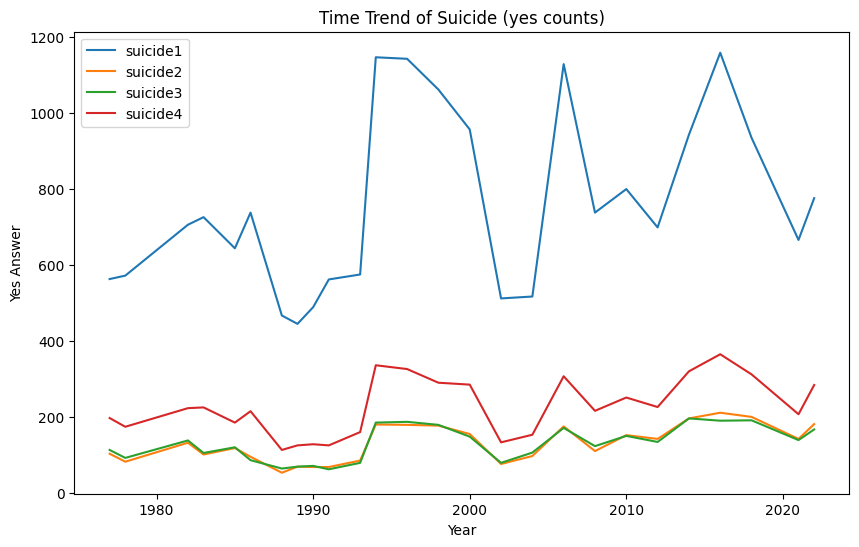

In [32]:
# Group by 'year' and calculate the sum for each vars
grouped_df = df.groupby('year').sum()

# Plot the time trend graph for yes count
plt.figure(figsize=(10, 6))

for col in ['suicide1', 'suicide2', 'suicide3', 'suicide4']:
    plt.plot(grouped_df.index, grouped_df[col], label=col)

plt.xlabel('Year')
plt.ylabel('Yes Answer')
plt.title('Time Trend of Suicide (yes counts)')
plt.legend()
plt.show()


In [18]:
# Create a crosstab for 'suicide1' by 'year' to check if the graph is drawn correctly
table_suicide1 = pd.crosstab(index=df['suicide1'], columns=df['year'])

# Display the table
print(table_suicide1)

year      1977  1978  1982  1983  1985  1986  1988  1989  1990  1991  ...  \
suicide1                                                              ...   
0.0        892   890  1004   768   799   657   450   488   353   405  ...   
1.0        563   572   706   726   644   738   467   445   489   562  ...   

year      2004  2006  2008  2010  2012  2014  2016  2018  2021  2022  
suicide1                                                              
0.0        339   748   505   538   508   641   623   516   311   317  
1.0        517  1129   738   800   699   943  1159   935   666   776  

[2 rows x 26 columns]


In [24]:
# calculate the percentage of yes/no (1/0) for each suicide variables by years
df_melted = pd.melt(df, id_vars='year', var_name='suicide_var', value_name='value')

# Calculate the percentage of counts of 0 and 1 for each suicide variable grouped by year
result_df = df_melted.groupby(['year', 'suicide_var', 'value']).size().unstack()
result_df['percent_0'] = result_df[0] / (result_df[0] + result_df[1]) * 100
result_df['percent_1'] = result_df[1] / (result_df[0] + result_df[1]) * 100

# Display the resulting DataFrame
print(result_df[['percent_0', 'percent_1']])

value             percent_0  percent_1
year suicide_var                      
1977 suicide1     61.305842  38.694158
     suicide2     92.920962   7.079038
     suicide3     92.233677   7.766323
     suicide4     86.460481  13.539519
1978 suicide1     60.875513  39.124487
...                     ...        ...
2021 suicide4     78.812692  21.187308
2022 suicide1     29.002745  70.997255
     suicide2     83.440073  16.559927
     suicide3     84.720952  15.279048
     suicide4     74.016468  25.983532

[104 rows x 2 columns]


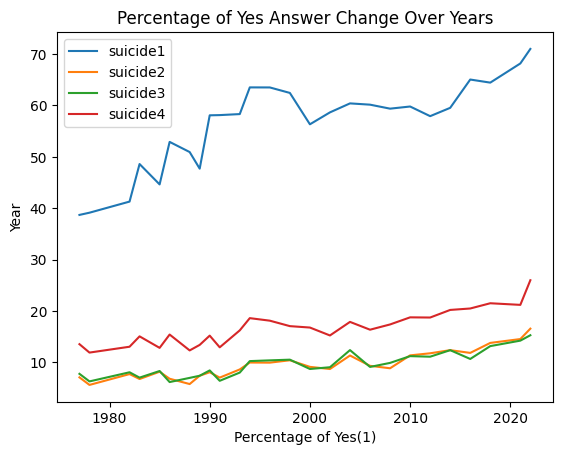

In [33]:
# fraw the time trend plot for suicide variables with percentage of yes
for var in ['suicide1', 'suicide2', 'suicide3', 'suicide4']:
    subset = result_df.loc[result_df.index.get_level_values('suicide_var') == var]
    plt.plot(subset.index.get_level_values('year'), subset['percent_1'], label=f'{var}')


plt.xlabel('Percentage of Yes(1)')
plt.ylabel('Year')
plt.title('Percentage of Yes Answer Change Over Years')
plt.legend()
plt.show()